Let’s start with revenue — the most general indicator that shows what income our delivery service generates.

For each day in the orders table, we will calculate the following indicators:

- Revenue received on that day.
- Total accumulated revenue up to the current day.
- Revenue growth for the current day relative to the previous day's revenue.

```SQL
with revenue as (SELECT creation_time::date as date,
                        sum(price) as revenue
                 FROM   (SELECT no.creation_time,
                                order_id,
                                no.product_id,
                                p.name,
                                p.price
                         FROM   (SELECT creation_time,
                                        order_id,
                                        unnest(product_ids) as product_id
                                 FROM   orders) as no
                             LEFT JOIN products p
                                 ON no.product_id = p.product_id
                         WHERE  order_id not in (SELECT order_id
                                                 FROM   user_actions
                                                 WHERE  action = 'cancel_order')) as t1
                 GROUP BY date)
SELECT date,
       revenue,
       sum(revenue) OVER (ORDER BY date) as total_revenue,
       round((revenue - lag (revenue) OVER (ORDER BY date))*100.0/ (lag(revenue) OVER (ORDER BY date))::integer,
             2) as revenue_change
FROM   revenue
```

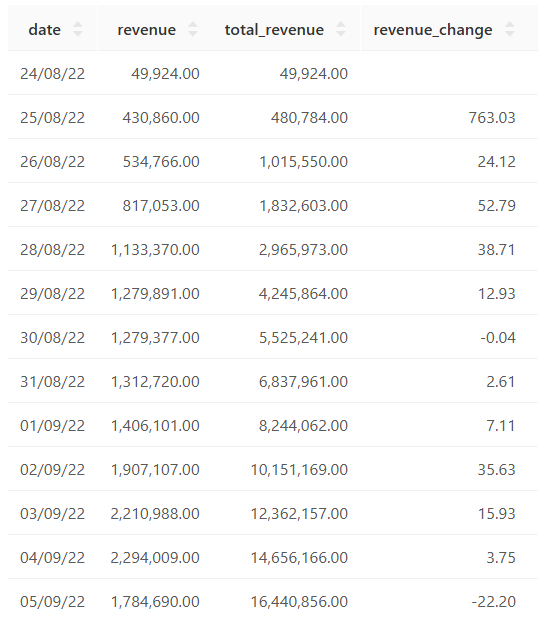

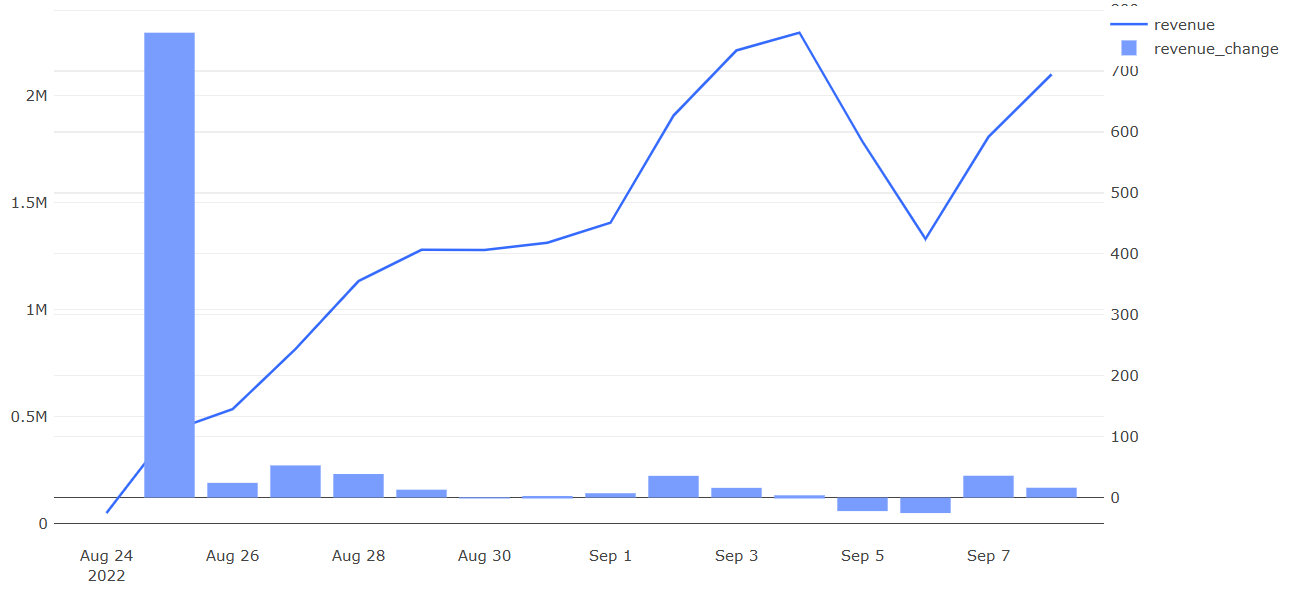

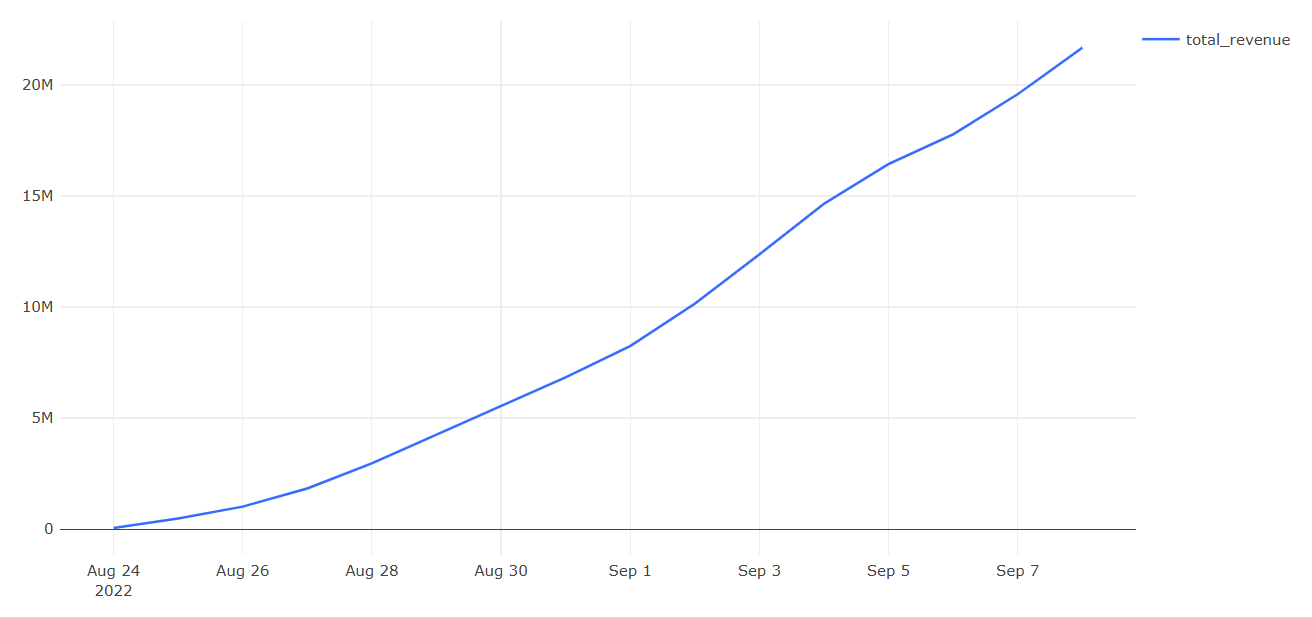

Now, based on the revenue data, we will calculate several relative indicators that show how much consumers are, on average, willing to pay for the services of our delivery service.
Let’s focus on the following metrics:

- For each day, we will calculate the following indicators:
- Revenue per user (ARPU) for the current day.
- Revenue per paying user (ARPPU) for the current day.
- Revenue per order, or average order value (AOV) for the current day.

```SQL
WITH orders_expanded AS (
    SELECT o.creation_time::DATE AS date, o.order_id, p.product_id, p.price
    FROM orders o
    CROSS JOIN LATERAL unnest(o.product_ids) AS product_id
    LEFT JOIN products p ON product_id = p.product_id
),
filtered_orders AS (
    SELECT date, order_id, SUM(price) AS revenue
    FROM orders_expanded
    WHERE order_id NOT IN (
        SELECT order_id FROM user_actions WHERE action = 'cancel_order'
    )
    GROUP BY date, order_id
),
revenue AS (
    SELECT date, SUM(revenue) AS total_revenue
    FROM filtered_orders
    GROUP BY date
),
users AS (
    SELECT time::DATE AS date, COUNT(DISTINCT user_id) AS total_users
    FROM user_actions
    GROUP BY date
),
paying_users AS (
    SELECT time::DATE AS date, COUNT(DISTINCT user_id) AS total_paying_users
    FROM user_actions
    WHERE order_id NOT IN (
        SELECT order_id FROM user_actions WHERE action = 'cancel_order'
    )
    GROUP BY date
),
orders AS (
    SELECT time::DATE AS date, COUNT(DISTINCT order_id) AS total_orders
    FROM user_actions
    WHERE action = 'create_order' 
    AND order_id NOT IN (
        SELECT order_id FROM user_actions WHERE action = 'cancel_order'
    )
    GROUP BY date
)
SELECT r.date,
       ROUND(total_revenue / NULLIF(total_users, 0), 2) AS arpu,
       ROUND(total_revenue / NULLIF(total_paying_users, 0), 2) AS arppu,
       ROUND(total_revenue / NULLIF(total_orders, 0), 2) AS aov
FROM revenue r
JOIN users u USING (date)
JOIN paying_users pu USING (date)
JOIN orders o USING (date)
ORDER BY r.date;
```

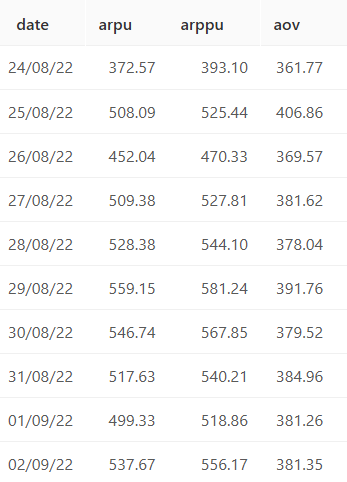

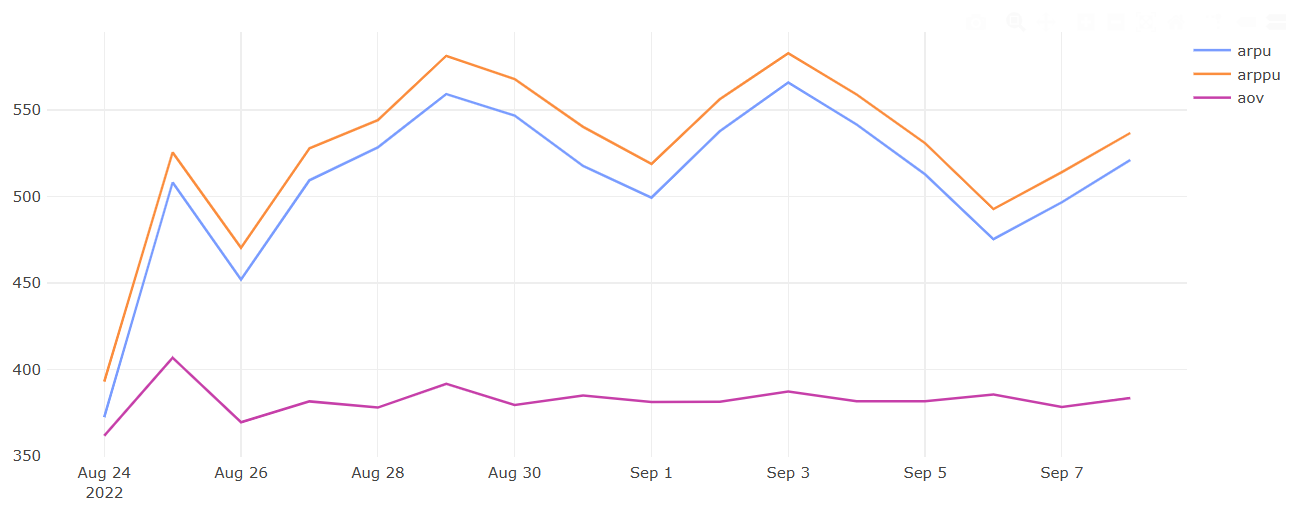

Conclusions:

ARPU and ARPPU show significant fluctuations, while AOV remains relatively stable. We can notice that some metrics have abnormally high or abnormally low values.

For example, on August 24, there is a sharp spike in ARPU and ARPPU,
which may be related to a promotion, price changes, or an increase in the number of active paying users.

There is also a sharp drop around September 5, which could be caused by a decrease in the number of transactions or a decrease in the average check.

The fluctuations in ARPU and ARPPU indicate that either the total number of users is changing unevenly,
or the number of paying users varies significantly.

Let’s supplement our analysis with even more interesting calculations — we’ll calculate the same metrics,
but for each day we will take into account the accumulated revenue and all available data on the number of users and orders as of that day.
This way, we will get dynamic ARPU, ARPPU, and AOV and will be able to trace how they changed over time as data came in.

For each day, calculate the following indicators:

- Accumulated revenue per user (Running ARPU).
- Accumulated revenue per paying user (Running ARPPU).
- Accumulated revenue per order, or average check (Running AOV).

```SQL
WITH revenue as (SELECT creation_time::date as date,
                        sum(price) as revenue
                 FROM   (SELECT no.creation_time,
                                order_id,
                                no.product_id,
                                p.name,
                                p.price
                         FROM   (SELECT creation_time,
                                        order_id,
                                        unnest(product_ids) as product_id
                                 FROM   orders) as no
                             LEFT JOIN products p
                                 ON no.product_id = p.product_id
                         WHERE  order_id not in (SELECT order_id
                                                 FROM   user_actions
                                                 WHERE  action = 'cancel_order')) as t1
                 GROUP BY date),

new_users as (SELECT date,
                              count(DISTINCT user_id) as new_users
                       FROM   (SELECT user_id,
                                      min(time::date) as date
                               FROM   user_actions
                               GROUP BY user_id) t2
                       GROUP BY date),
                 
                 
paying_users as (SELECT date,
                      count(DISTINCT user_id) as paying_users
               FROM   (SELECT user_id,
                              min(time::date) as date
                       FROM   user_actions
                       WHERE  order_id not in (SELECT order_id
                                               FROM   user_actions
                                               WHERE  action = 'cancel_order')
                       GROUP BY user_id) t3
               GROUP BY date
), 
               
orders as (SELECT time::date as date,
                       count(distinct order_id) as orders
                FROM   user_actions
                WHERE  action = 'create_order'
                   and order_id not in (SELECT order_id
                                     FROM   user_actions
                                     WHERE  action = 'cancel_order')
                GROUP BY date)
           
SELECT date, 
      ROUND(SUM(revenue) OVER (ORDER BY date) / NULLIF(SUM(new_users) OVER (ORDER BY date), 0), 2) AS running_arpu,
      ROUND(SUM(revenue) OVER (ORDER BY date) / NULLIF(SUM(paying_users) OVER (ORDER BY date), 0), 2) AS running_arppu,
      ROUND(SUM(revenue) OVER (ORDER BY date) / NULLIF(SUM(orders) OVER (ORDER BY date), 0), 2) AS running_aov
FROM revenue r JOIN new_users u USING(date)
     JOIN paying_users pu USING(date)
     JOIN orders o USING(date)
ORDER BY date
```

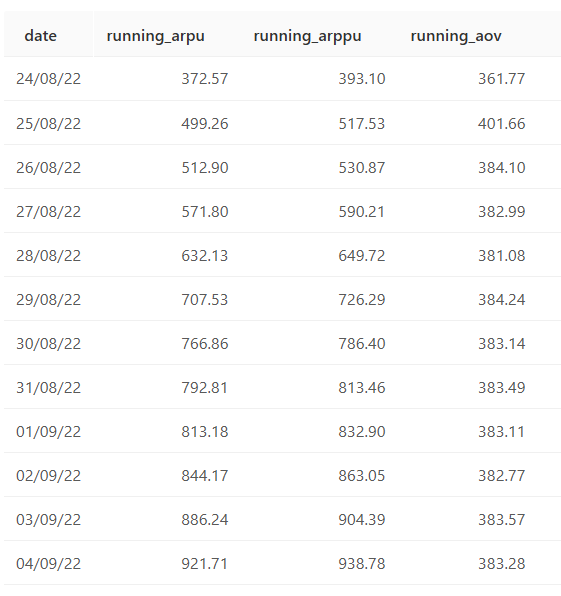

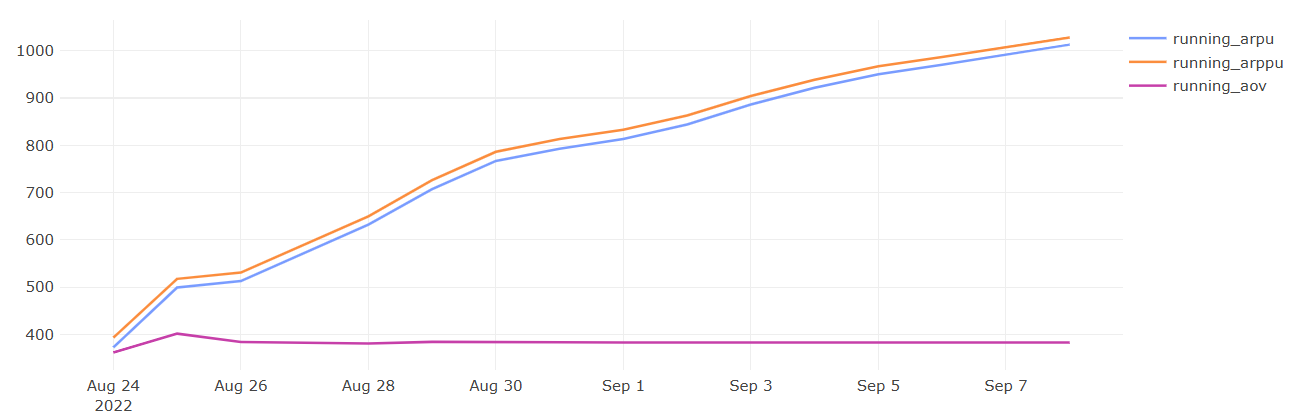

Conclusions:

- running_arpu and running_arppu demonstrate stable growth over time.
This indicates an increase either in the number of orders or in the average check per user.
- running_aov remains approximately at the same level, with minor fluctuations.
- Since running_arpu and running_arppu are growing, and running_aov is not changing,
we can assume that revenue growth is occurring due to an increase in the number of orders per user,
and not due to an increase in the average check.
- This may indicate that users are starting to place orders more frequently,
which is a positive trend for the business.

Let’s calculate the same metrics, but from a different perspective — not just by individual days, but by days of the week.

For each day of the week, using the orders and user_actions tables, calculate the following metrics:

- Revenue per user (ARPU)
- Revenue per paying user (ARPPU)
- Revenue per order (AOV)

When performing the calculations, consider only the period from August 26, 2022 to September 8, 2022 inclusive — so that the analysis includes an equal number of each day 
of the week (exactly two of each day).

```SQL
WITH revenue AS (
    SELECT trim(to_char(creation_time, 'Day')) AS weekday,
    to_char(creation_time, 'ID')::int AS weekday_number, SUM(price) AS revenue
    FROM (
        SELECT no.creation_time::date as creation_time, order_id, no.product_id, p.name, p.price
        FROM (
            SELECT creation_time, order_id, UNNEST(product_ids) AS product_id
            FROM orders
        ) AS no
        LEFT JOIN products p ON no.product_id = p.product_id
        WHERE order_id NOT IN (
            SELECT order_id FROM user_actions WHERE action = 'cancel_order'
        ) and creation_time BETWEEN '2022-08-26' AND '2022-09-09'
    ) AS t1
    GROUP BY weekday, weekday_number
),

users as (SELECT trim(to_char(time::date, 'Day')) AS weekday,
                 to_char(time::date, 'ID')::int AS weekday_number,
                                 count(distinct user_id) as users
                          FROM   user_actions
                          WHERE time::date BETWEEN '2022-08-26' AND '2022-09-09'
                          GROUP BY weekday, weekday_number),
                              
paying_users AS (
    SELECT trim(to_char(time::date, 'Day')) AS weekday,
                 to_char(time::date, 'ID')::int AS weekday_number,
     COUNT(DISTINCT user_id) AS paying_users
    FROM user_actions
    WHERE order_id NOT IN (
        SELECT order_id FROM user_actions WHERE action = 'cancel_order'
    ) and time::date BETWEEN '2022-08-26' AND '2022-09-09'
    GROUP BY weekday, weekday_number
),
orders AS (
    SELECT trim(to_char(time::date, 'Day')) AS weekday,
                 to_char(time::date, 'ID')::int AS weekday_number,
    COUNT(DISTINCT order_id) AS orders
    FROM user_actions
    WHERE action = 'create_order' 
      AND order_id NOT IN (
          SELECT order_id FROM user_actions WHERE action = 'cancel_order'
      ) and time::date BETWEEN '2022-08-26' AND '2022-09-09'
    GROUP BY weekday, weekday_number
)

SELECT  revenue.weekday, revenue.weekday_number::numeric(3,1) as weekday_number,
    ROUND(revenue / users, 2) AS arpu,
    ROUND(revenue / paying_users, 2) AS arppu,
    ROUND(revenue / orders, 2) AS aov
FROM revenue 
JOIN users USING(weekday)
JOIN paying_users USING(weekday)  
JOIN orders USING(weekday)
ORDER BY weekday_number;
```

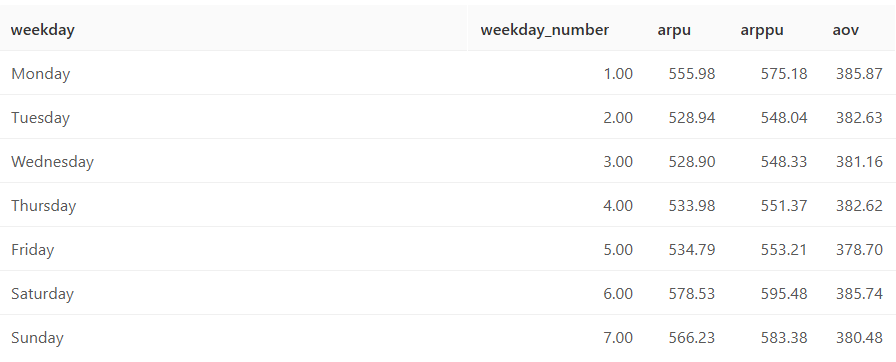

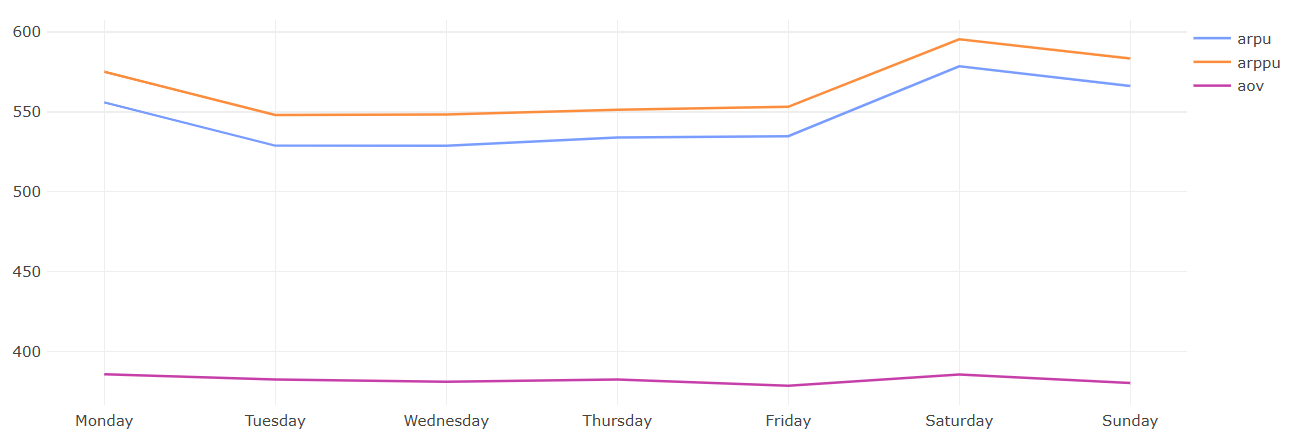

Conclusions:
The highest values of ARPU and ARPPU occurred on the weekend days — Saturday and Sunday. Overall, this aligns with standard user behavior for a food delivery service. On weekends, people tend to order food more often as they cook less at home and spend more time relaxing.

We can see that on the days when ARPU and ARPPU reached their highest values, the AOV metric remained approximately the same. This could be due to an increase in the number of orders during weekends, while the average order value stays about the same. Or it may happen because of a larger number of users placing standard orders. 

This is possible in the following scenarios:

- An increase in the number of orders with no change in the average value per order
- Attracting more users, but without a significant increase in their average check
- Growth in the number of small orders
- Order frequency increases, but order value remains unchanged